In [27]:
# Import libraries
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.dummy import DummyRegressor
from model_screener import ModelScreener
from rdkit import Chem
from rdkit.Chem import Draw
sns.set_style()

In [2]:
# Read data
file_path = Path("../data/dataset_processed.csv")
dataset = pd.read_csv(file_path)

# Model Screening

Two parallel screening approaches are followed:
1. Chemical descriptors describing rings as integer values
2. Chemical descriptors describing rings as categories (no ring or ring(s))

A Random Forest model is build to check for feature importance in order to reduce the features to the smallest possible set for screening.

## Random Forest Feature Importance

In [3]:
# Define data
y_cont = dataset.loc[:, "Solubility"]
y_cat = dataset.loc[:, "solubility_enc"]
columns_cont = [
    "MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHDonors", 
    "NumRotatableBonds", "NumValenceElectrons", "NumAromaticRings",
    "NumAliphaticRings", "NumSaturatedRings", "RingCount", "LabuteASA", 
    "BertzCT", "C", "Cl", "Na", "Br", "F", "K", "O"
    ]
columns_cat = [
    "MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHDonors", 
    "NumRotatableBonds", "NumValenceElectrons", "RingCount_cat", 
    "NumAromaticRings_cat", "NumSaturatedRings_cat", "LabuteASA",
    "NumAliphaticRings_cat", "BertzCT", "C", "Cl", "Na", "Br", "F", "K", "O"
    ]

# Extract 2 different datasets
x_cont = dataset.loc[:, columns_cont]
x_cat = dataset.loc[:, columns_cat]
# Transform dataframes into numpy arrays
x_cont = x_cont.values
x_cat = x_cat.values
y_cat = y_cat.values
y_cont = y_cont.values

# Check shape
print(f"x_train_cont shape: {x_cont.shape}")
print(f"x_train_cat shape: {x_cat.shape}")

x_train_cont shape: (9489, 20)
x_train_cat shape: (9489, 20)


OOB score: 0.7796025669332302


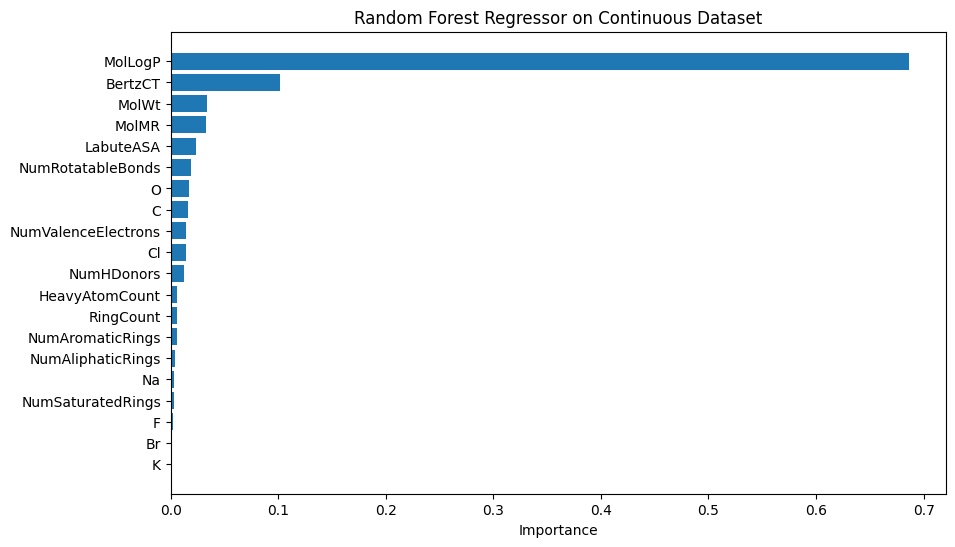

In [4]:
# Setup Random forest regressor on continuous dataset
forest_regressor = (RandomForestRegressor(
    n_jobs=-1, oob_score=True, random_state=42)
                    .fit(X=x_cont, y=y_cont)
)

# Get feature importances and oob score
feature_importances = forest_regressor.feature_importances_
print(f"OOB score: {forest_regressor.oob_score_}")

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': columns_cont, 'Importance': feature_importances})

# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Regressor on Continuous Dataset')
plt.show()

OOB score: 0.779180896691998


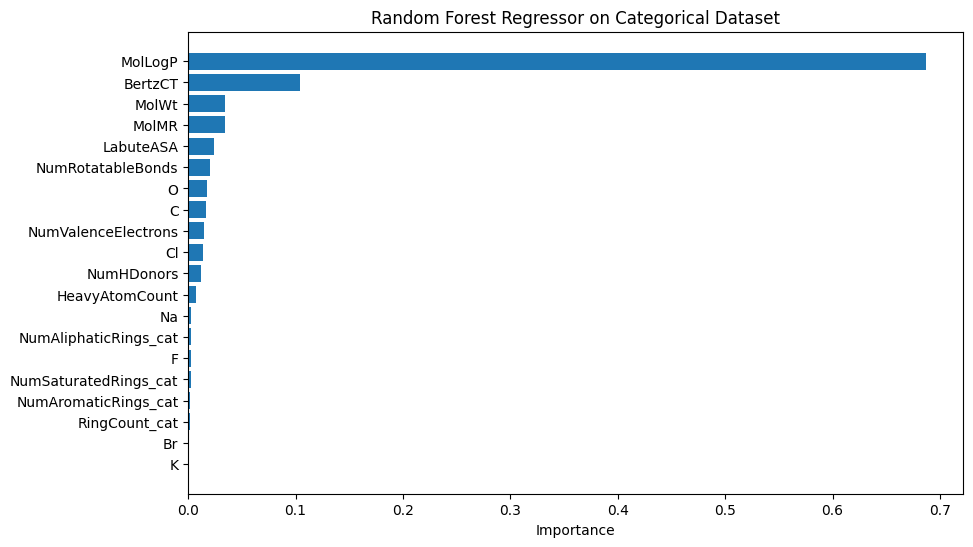

In [5]:
# Setup Random forest classifier on categorical dataset
forest_regressor = (RandomForestRegressor(
    n_jobs=-1, oob_score=True, random_state=42)
                    .fit(X=x_cat, y=y_cont)
)

# Get feature importances and oob score
feature_importances = forest_regressor.feature_importances_
print(f"OOB score: {forest_regressor.oob_score_}")

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': columns_cat, 'Importance': feature_importances})

# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Regressor on Categorical Dataset')
plt.show()

**Conclusions**:
- Categorical features perform worse than continuous features
- The most important feature is by far the partition coefficient followed by BertzCT and the molecular weights

The Partition coefficient is by far the most important feature, which is in accordance to the correlation coefficient. BertzCT is the second most important feature which is different to the correlation matrix.

The general trend is that chemical descriptors that describe accessible surface areas, branching or other more topological features are way more important the the simple atom types descriptors.

## Model Screening

In [6]:
# Split dataset
labels = dataset.loc[:, "Solubility"]
data = dataset.drop(columns=["Solubility"])
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(data, labels, test_size=0.2, random_state=42)

# Save datasets as csv
X_train_cont.to_csv(Path("../data/train_data.csv"), index=False)
X_test_cont.to_csv(Path("../data/test_data.csv"), index=False)
y_train_cont.to_csv(Path("../data/train_labels.csv"), index=False)
y_test_cont.to_csv(Path("../data/test_labels.csv"), index=False)

# Keep columns of interest
columns_cont = [
    "MolWt",
    "MolLogP", 
    "MolMR", 
    "HeavyAtomCount", 
    "NumHDonors", 
    "NumRotatableBonds", 
    "NumValenceElectrons",
    "NumAromaticRings", 
    "LabuteASA", 
    "BertzCT",
    "C", 
    "Cl", 
    "Na", 
    "Br", 
    "F", 
    "K", 
    "O"
    ]

X_train_cont = X_train_cont.loc[:, columns_cont]
X_test_cont = X_test_cont.loc[:, columns_cont]

In [7]:
# Create a dictionary of regression models
regression_models = {
    "dummy": DummyRegressor(),
    'linear_regression': LinearRegression(),
    'svr': SVR(),
    'random_forest': RandomForestRegressor(),
    'gb_regression': GradientBoostingRegressor(),
    'knn_regression': KNeighborsRegressor(),
    'mlp_regression': MLPRegressor(random_state=42),
    'adaboost': AdaBoostRegressor(random_state=42)
}

# Set up screening object for regression and continuous ring values
regression_screener_cont = ModelScreener(
    x_train=X_train_cont,
    y_train=y_train_cont,
    models=regression_models,
    metrics="neg_root_mean_squared_error",
    cv=5)

# Perform screening for regression
regression_screener_cont.screen_models()
# Transform results into dataframe
regression_screener_cont.transform_to_df()
results = regression_screener_cont.results_df
# Convert negative RMSE to absolute values
results = results.assign(score_mean=results.loc[:, "score_mean"].abs())

/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

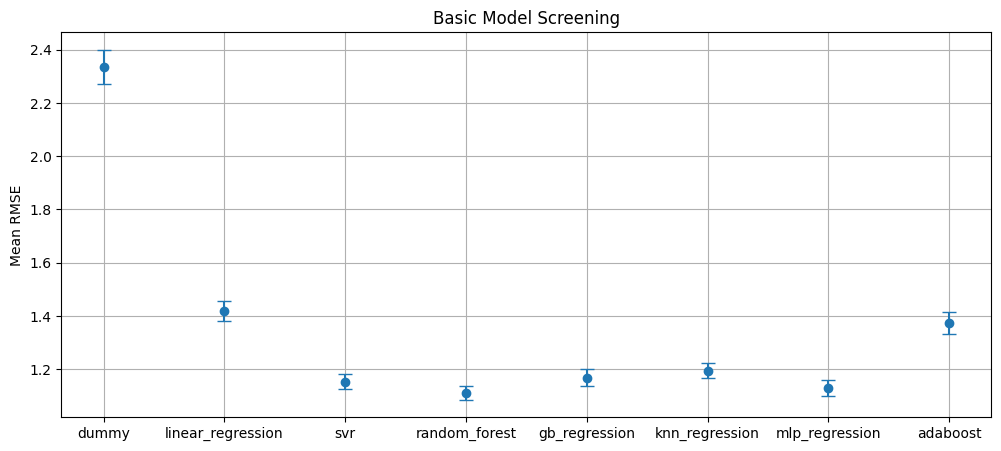

In [8]:
# Plot results
plt.figure(figsize=(12,5))
plt.errorbar(results.index, results['score_mean'], yerr=results['score_stdev'], fmt='o', capsize=5)
plt.ylabel("Mean RMSE")
plt.title("Basic Model Screening")
plt.grid(True)
plt.show()

**Conclusion**:
- The models perform mostly equally well except for the simple linear regression and adaboost

# Fine tuning

Models:
- SVR 
- GradientBoosting regressor
- KNN regressor
- MLP regressor

In [9]:
# Define hyperparameter space for GradientBoosting Regressor
gb_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

# Perform random search for GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor()
gb_random_search = RandomizedSearchCV(
    gb_regressor, param_distributions=gb_params,
    n_iter=50, cv=3, scoring='neg_root_mean_squared_error',
    verbose=1, n_jobs=-1, random_state=42)
gb_random_search.fit(X_train_cont, y_train_cont)

#--------------------------------------------------------------

# Define hyperparameter space for SVR
svr_params = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

# Perform random search for SVR
svr_regressor = SVR()
svr_random_search = RandomizedSearchCV(
    svr_regressor, param_distributions=svr_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
svr_random_search.fit(X_train_cont, y_train_cont)

#--------------------------------------------------------------

# Define hyperparameter space for MLPRegressor
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25), (50, 50, 50, 50, 50)],
    'activation': ['relu', 'tanh'],
    "solver": ["adam"],
    'alpha': np.logspace(-5, 2, 8),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': randint(100, 500)
}

# Perform random search for MLP
mlp_regressor = MLPRegressor()
mlp_random_search = RandomizedSearchCV(
    mlp_regressor, param_distributions=mlp_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
mlp_random_search.fit(X_train_cont, y_train_cont)

#--------------------------------------------------------------

# Define hyperparameter space for KNN regressor
knn_params = {
    'n_neighbors': randint(1, 21),              
    'weights': ['uniform', 'distance'],
    }

# Perform random search for KNN regressor
knn_regressor = KNeighborsRegressor()
knn_random_search = RandomizedSearchCV(
    knn_regressor, param_distributions=knn_params, n_iter=50,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error',
    random_state=42)
knn_random_search.fit(X_train_cont, y_train_cont)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (206) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (221) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (289) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (148) reac

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc8967d4500>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [10]:
# Access the best hyperparameters, best models and best scores
best_gb_params = gb_random_search.best_params_
best_gb_model = gb_random_search.best_estimator_
best_gb_score = gb_random_search.best_score_

best_svr_params = svr_random_search.best_params_
best_svr_model = svr_random_search.best_estimator_
best_svr_score = svr_random_search.best_score_

best_mlp_params = mlp_random_search.best_params_
best_mlp_model = mlp_random_search.best_estimator_
best_mlp_score = mlp_random_search.best_score_

best_knn_params = knn_random_search.best_params_
best_knn_model = knn_random_search.best_estimator_
best_knn_score = knn_random_search.best_score_

# Create dataframe
fine_tuning_df = pd.DataFrame(
    data=[
        [best_gb_params, abs(best_gb_score)],
        [best_svr_params, abs(best_svr_score)],
        [best_mlp_params, abs(best_mlp_score)],
        [best_knn_params, abs(best_knn_score)]
        ],
    columns=["Best params", "Best score"],
    index=["GB", "SVR", "MLP", "KNN"])
fine_tuning_df

,Best params,Best score
GB,"{'learning_rate': 0.09583588048137198, 'max_de...",1.116040
SVR,"{'C': 9.756320330745593, 'gamma': 'auto'}",1.112703
MLP,"{'activation': 'tanh', 'alpha': 1e-05, 'hidden...",1.090443
KNN,"{'n_neighbors': 12, 'weights': 'distance'}",1.166939


In [16]:
# Save best models
filepath_gb = Path("../models/gb_desc.pkl")
filepath_svr = Path("../models/svr_desc.pkl")
filepath_mlp = Path("../models/mlp_desc.pkl")
filepath_knn = Path("../models/knn_desc.pkl")

joblib.dump(best_gb_model, filepath_gb )
joblib.dump(best_svr_model, filepath_svr)
joblib.dump(best_mlp_model, filepath_mlp)
joblib.dump(best_knn_model, filepath_knn)

['../models/knn_desc.pkl']

# Ensemble model

- Voting regressor to combine all 4 models
- Stacking regressor to combine all 4 models with LinearRegression as final estimator

In [12]:
# Setup estimator list
estimators=[("gb", best_gb_model), ("svr", best_svr_model), ("mlp", best_mlp_model), ("knn", best_knn_model)]

# Setup voting regressor
voting_regressor = VotingRegressor(
    estimators=estimators,
    n_jobs=-1
)

voting_regressor.fit(X_train_cont, y_train_cont)

# Calculate scores
voting_scores = cross_val_score(
    estimator=voting_regressor, 
    X=X_train_cont, 
    y=y_train_cont,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
    )

print(f"Voting regressor RMSE mean {voting_scores.mean(): .2f} +/- {voting_scores.std(): .2f}")

/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reac

Voting regressor RMSE mean -1.05 +/-  0.03


In [13]:
# Setup stacking regressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    passthrough=False,
    n_jobs=-1
    )

stacking_regressor.fit(X_train_cont, y_train_cont)

# Calculate scores
stacking_scores = cross_val_score(
    estimator=stacking_regressor, 
    X=X_train_cont, 
    y=y_train_cont,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
    )

print(f"Stacking regressor RMSE mean {stacking_scores.mean(): .2f} +/- {stacking_scores.std(): .2f}")

/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (406) reac

Stacking regressor RMSE mean -1.05 +/-  0.03


Both the voting and stacking ensemble models perform slightly better than the best underlying model.

In [14]:
# Save ensemble models
filepath_voting = Path("../models/voting_desc.pkl")
filepath_stacking = Path("../models/stacking_desc.pkl")

joblib.dump(voting_regressor, filepath_voting)
joblib.dump(stacking_regressor, filepath_stacking)

['../models/stacking_desc.pkl']

## Evaluate models on test set

In [17]:
# Load models
best_gb_model = joblib.load("../models/gb_desc.pkl")
best_knn_model = joblib.load("../models/knn_desc.pkl")
best_mlp_model = joblib.load("../models/mlp_desc.pkl")
best_svr_model = joblib.load("../models/svr_desc.pkl")
voting_regressor = joblib.load("../models/voting_desc.pkl")
stacking_regressor = joblib.load("../models/stacking_desc.pkl")

In [18]:
# Compare performances of all models on test set
models = {
    "GB Regressor": best_gb_model,
    "KNN": best_knn_model, 
    "MLP": best_mlp_model, 
    "SVR": best_svr_model, 
    "Voting": voting_regressor, 
    "Stacking": stacking_regressor
}

model_results = {}
for model_name, model in models.items():
    predictions = model.predict(X_test_cont)
    rmse_score = root_mean_squared_error(y_pred=predictions, y_true=y_test_cont)
    model_results[model_name] = rmse_score

for model, score in model_results.items():
    print(f"{model}: {score:.2f}")

GB Regressor: 1.09
KNN: 1.14
MLP: 1.05
SVR: 1.06
Voting: 1.01
Stacking: 1.02


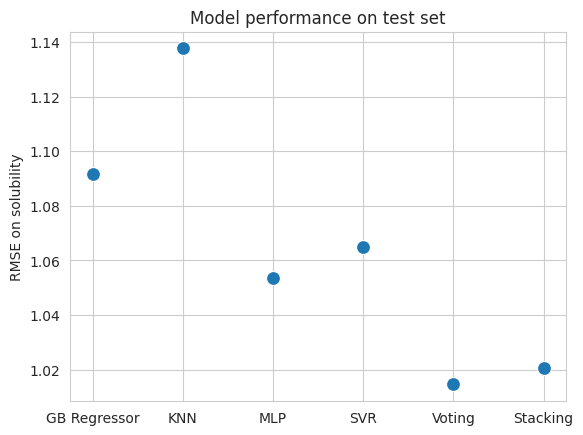

In [19]:
# Plot results
sns.set_style("whitegrid")
sns.scatterplot(data=model_results, s=100, )
plt.ylabel("RMSE on solubility")
plt.title("Model performance on test set")
plt.show()

# Error analysis

In [20]:
# Get predictions of voting classifier
voting_predictions = voting_regressor.predict(X_test_cont)
# Create dataframe for error analysis
error_analysis_df = X_test_cont.assign(
    solubility=y_test_cont,
    prediction=voting_predictions)
# Add residuals
error_analysis_df = error_analysis_df.assign(
    residual=error_analysis_df["solubility"] - error_analysis_df["prediction"])
# Extract name and smiles from original dataset
name_and_smiles = dataset.iloc[error_analysis_df.index, ].loc[:, ["Name", "SMILES"]]
error_analysis_df = error_analysis_df.assign(
    name=name_and_smiles.loc[:, "Name"],
    smiles=name_and_smiles.loc[:, "SMILES"]
)

error_analysis_df

,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHDonors,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,LabuteASA,BertzCT,...,Na,Br,F,K,O,solubility,prediction,residual,name,smiles
2210,-0.630701,-0.095967,-0.477729,-0.539827,-0.072923,-0.417308,-0.456287,-0.907880,-0.545013,-0.664616,...,-0.161261,-0.134458,-0.153927,-0.060251,-0.286636,-1.799728,-1.369970,-0.429759,2-(5-ethenyl-5-methyloxolan-2-yl)propan-2-ol,CC(C)(O)C1CCC(C)(O1)C=C
2907,-0.531026,-1.429977,-0.645826,-0.539827,3.553755,-0.417308,-0.335662,-0.907880,-0.613853,-0.939872,...,-0.161261,-0.134458,-0.153927,-0.060251,1.004656,0.734729,0.451861,0.282869,carbonic acid - 2-aminoethanol (1:2),NCCO.NCCO.OC(O)=O
1530,2.184429,-1.790443,1.503656,2.010913,3.553755,0.409984,2.036627,0.792647,1.800418,2.387362,...,-0.161261,-0.134458,-0.153927,-0.060251,2.726378,-7.751247,-1.819935,-5.931312,"1H-Pyrazole-3-carboxylic acid, 4,5-dihydro-5-o...",[H+].[Cl-].NC(N)=N.OC(=O)C1=NN(c2ccc(cc2)[S](O...
6465,0.321051,-0.100656,0.389629,0.522981,-0.798259,-0.210485,0.508712,-0.057616,0.408574,0.260661,...,-0.161261,-0.134458,-0.153927,-0.060251,0.574225,-2.226700,-2.853673,0.626973,cocaine,COC(=O)[C@H]1[C@H](CC2CCC1N2C)OC(=O)c3ccccc3
4075,-1.071763,-0.407946,-1.086394,-1.177512,-0.072923,-0.624131,-1.099620,-0.907880,-1.082802,-1.015543,...,-0.161261,-0.134458,-0.153927,-0.060251,-0.717067,0.160200,0.050531,0.109669,"2-propanol, 1-chloro-2-methyl-",CC(C)(O)CCl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,-0.730684,0.202544,-0.519720,-0.646108,-0.072923,-0.210485,-0.536704,-0.907880,-0.621013,-0.879191,...,-0.161261,-0.134458,-0.153927,-0.060251,-0.717067,-2.767362,-2.432399,-0.334963,4-cyclohexylbutan-2-ol,CC(O)CCC1CCCCC1
9014,0.392834,0.854847,0.701582,0.629262,0.652412,0.823631,0.589129,0.792647,0.526259,0.454589,...,-0.161261,-0.134458,-0.153927,-0.060251,0.143794,-3.470000,-4.361616,0.891616,5-hexoxy-2-[(~{E})-~{N}-hydroxy-~{C}-phenylcar...,CCCCCCOC1=CC(O)=C(C(=NO)C2=CC=CC=C2)C=C1
5812,0.486074,1.575017,0.295142,-0.008423,-0.798259,-0.624131,-0.094413,0.792647,0.309978,0.255920,...,-0.161261,-0.134458,-0.153927,-0.060251,-1.147498,-6.779800,-7.650075,0.870275,"1,1'-biphenyl, 2,2',3,4,6'-pentachloro-",Clc1ccc(c(Cl)c1Cl)c2c(Cl)cccc2Cl
2175,2.203871,-0.332397,2.121923,2.223475,-0.798259,1.444100,2.117044,1.642911,2.440476,2.229409,...,3.000328,-0.134458,-0.153927,-0.060251,1.435086,-0.406689,-0.705939,0.299250,sodium 4-{[4-(diethylamino)phenyl][4-(diethyli...,[Na+].CCN(CC)c1ccc(cc1)[C+](c2ccc(cc2)N(CC)CC)...


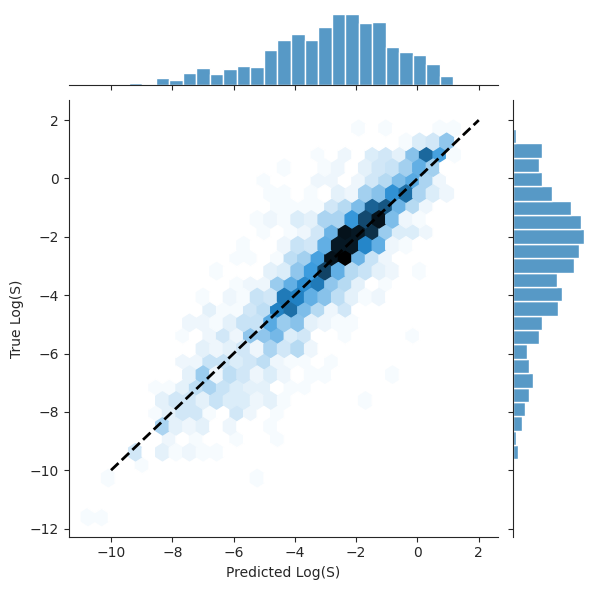

In [21]:
# Create parity plot
sns.set_style("ticks")
sns.jointplot(x=error_analysis_df.loc[:, "prediction"], y=error_analysis_df.loc[:, "solubility"], kind="hex")
x_line = np.linspace(-10, 2, 100)
y_line = x_line
plt.plot(x_line, y_line, color='black', linestyle='--', linewidth=2, label='y = x')
plt.xlabel('Predicted Log(S)')
plt.ylabel('True Log(S)')
plt.show()

In [22]:
# Mark overestimated and underestimated entries
top10_underestimated = error_analysis_df.sort_values(by="residual").iloc[:10,]
top10_overestimated = error_analysis_df.sort_values(by="residual").iloc[-10:,]

def error_classification(residual: float) -> str:
    if residual >= 2:
        return "overestimated"
    elif residual <= -2:
        return "underestimated"
    else:
        return "normal"
    
errors_organic = error_analysis_df.assign(error_class=error_analysis_df["residual"].apply(error_classification))

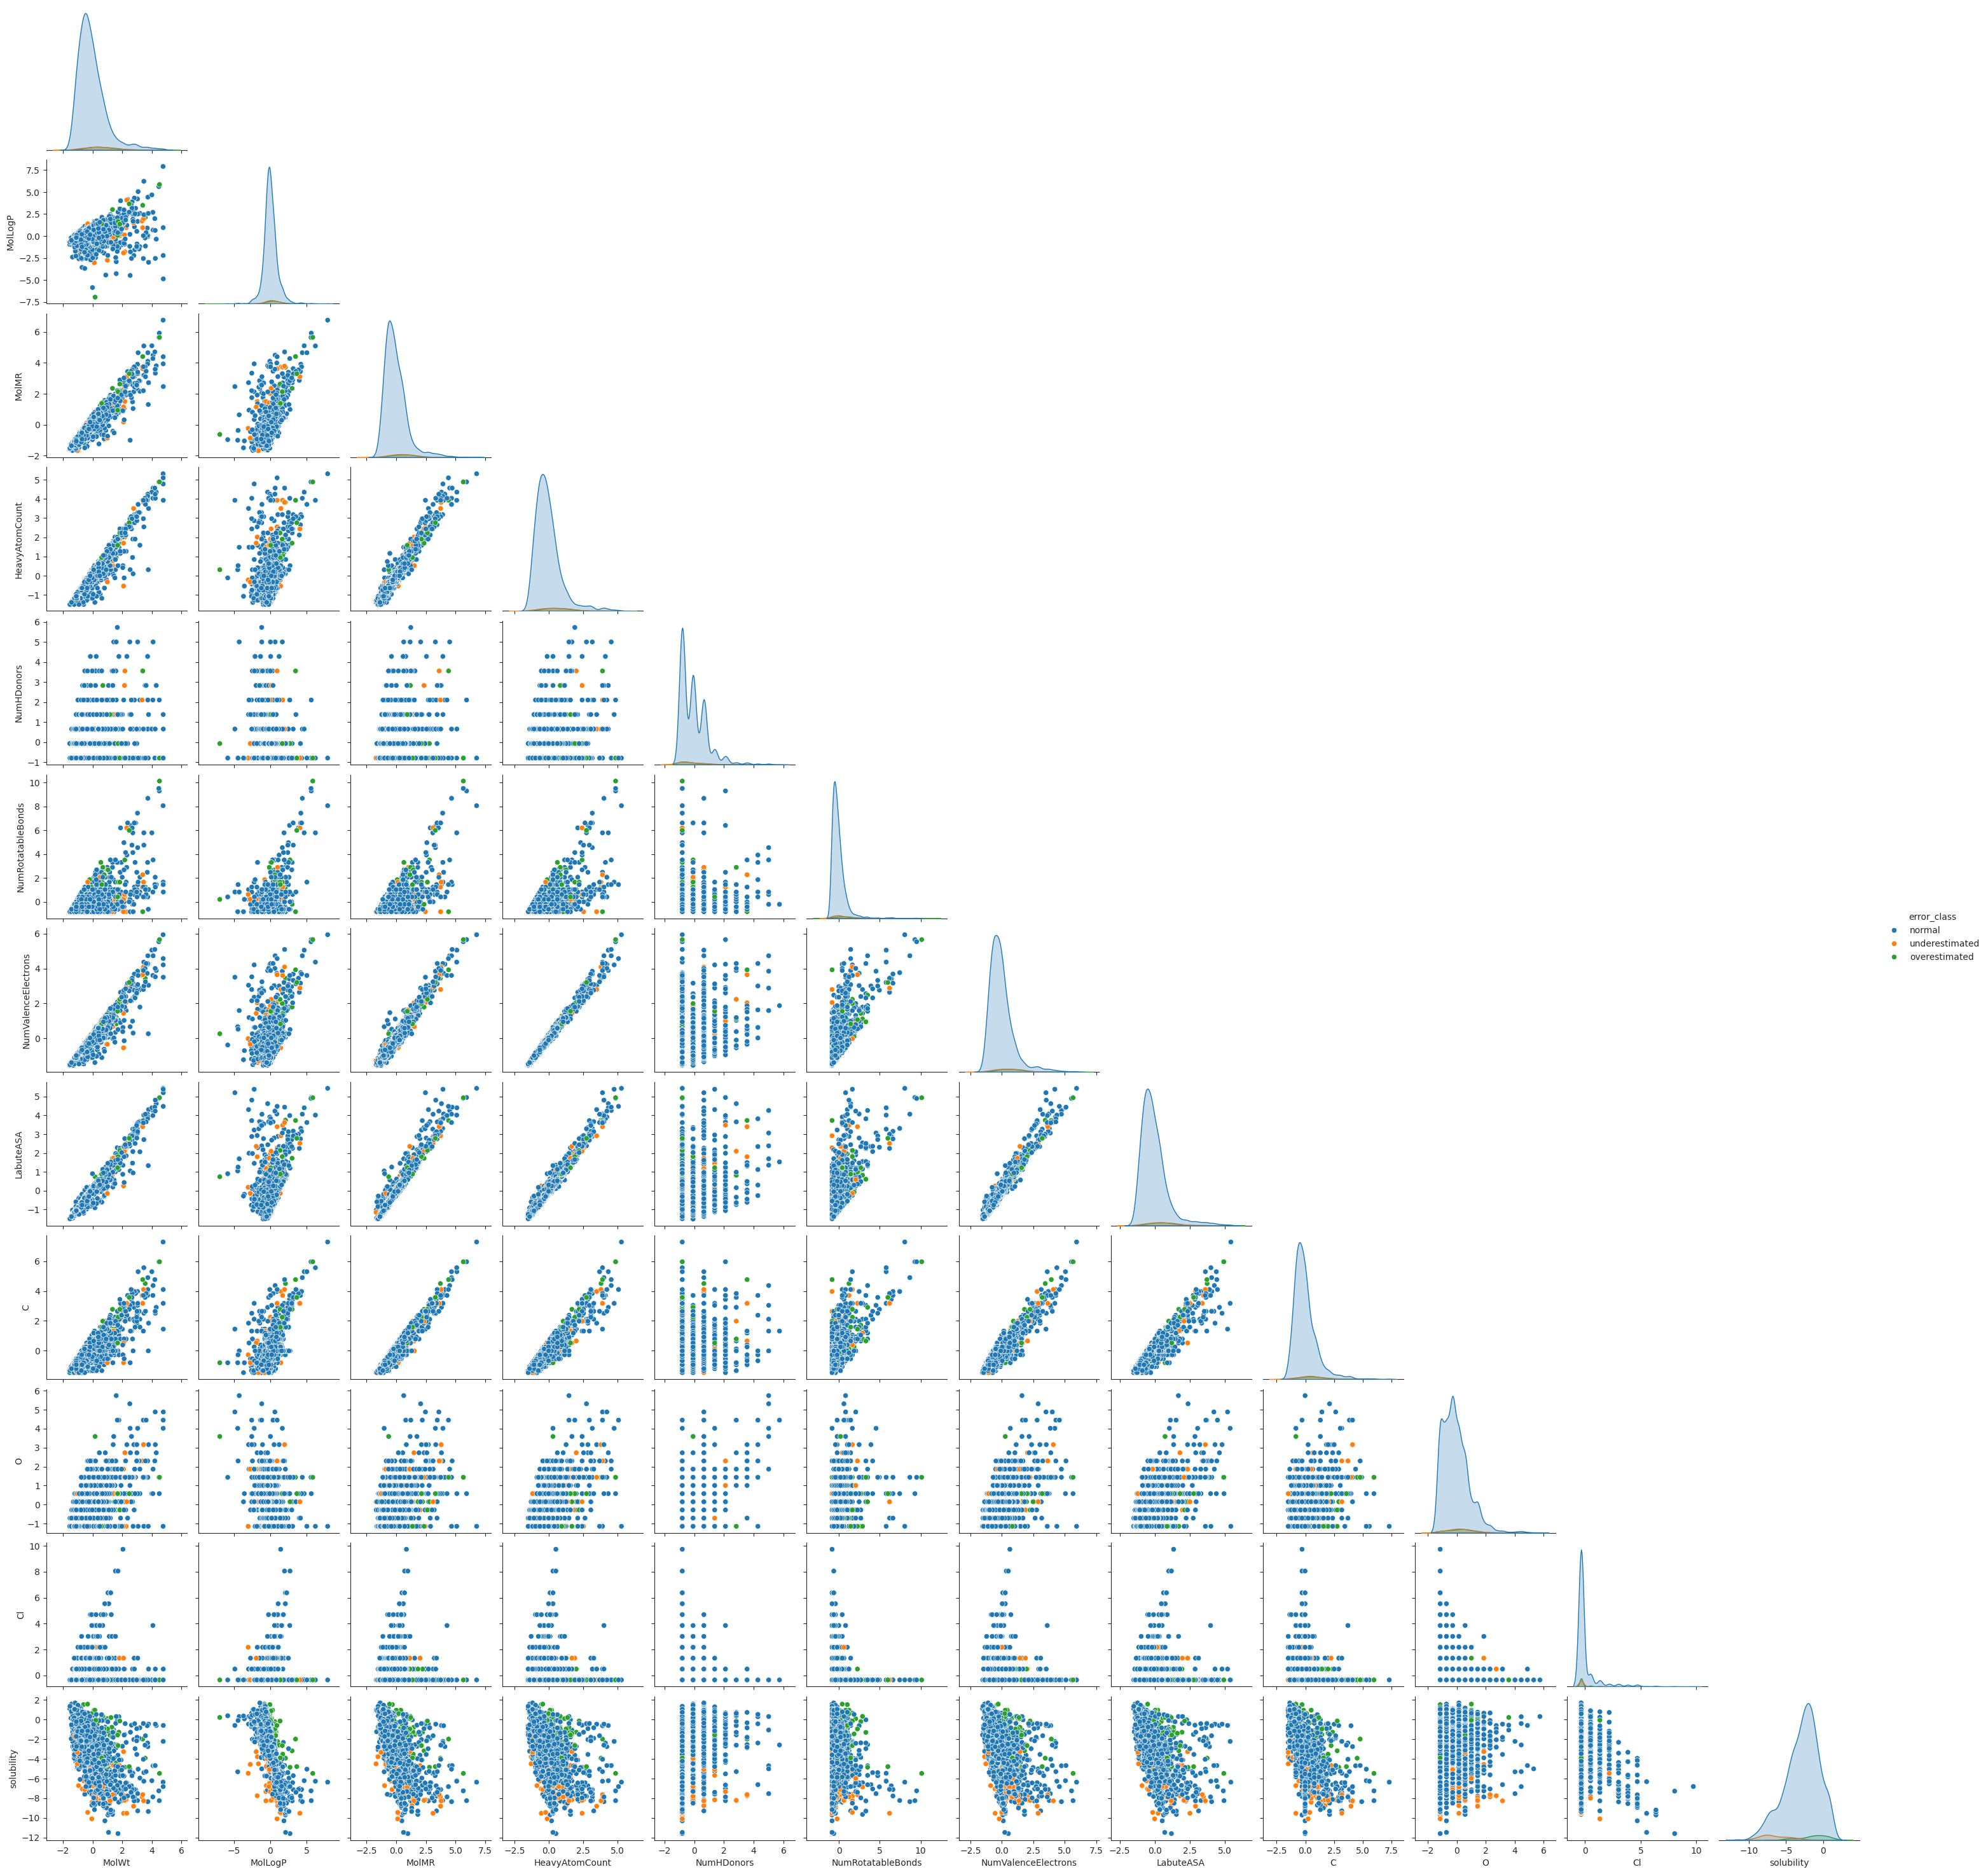

In [34]:
features_of_interest = ['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHDonors',
       'NumRotatableBonds', 'NumValenceElectrons', 'LabuteASA', 'C', 'O', 'Cl',
       'solubility']
sns.pairplot(
    data=errors_organic, 
    corner=True, 
    hue="error_class",
    x_vars=features_of_interest,
    y_vars=features_of_interest)
plt.show()